# README

This takes the data generated from gen_2DWindow_data.py and converts it into graphs. This experiment is taking 12 curves where there are windows around the null points. These windows around the null points are varied to show how close we need to be to the null point to have improved MSE beyond the conventional method. This code is changed from the npWindow experiment in that both windows vary in the central location. We also allow the SNR to vary.

# Libraries

In [1]:
#Preparing all libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
# import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
import colorsys
from datetime import date
import pickle
import functools
import os
from matplotlib.ticker import MultipleLocator

# Initialization

### Window Analysis

In [2]:


cwd_temp = os.getcwd()
base_file = 'Stabilization'
cwd_full = cwd_temp.split(base_file, 1)[0]
print(cwd_full)

exp_file = 'Window2D_Data'
exp_date = '15Nov23'

spacing = 15           #how far did the windows spread around center --> 2*spacing
method = "AIC"

param_oi = 2

assert(param_oi >= 0 and param_oi < 6)

ParamTitle_6p = [r'$T_{11}$', r'$T_{12}$', r'$c_1$', r'$c_2$', r'$T_{21}$', r'$T_{22}$']

/home/hamptong2/


In [3]:
with open(f'{cwd_full}{base_file}/Espresso_Method/{exp_file}/hprParameter_{method}_sp_{spacing}_{exp_date}.pkl', 'rb') as handle:
    
    dict = pickle.load(handle)
    rad_diff = dict['rad_diff']
    center1_array = dict['center1_array']
    center2_array = dict['center2_array']
    SNR_values = dict["SNR_values"]
    true_params = dict["true_params"]
    nTE = dict["nTE"]
    dTE = dict["dTE"]
    var_reps = dict["var_reps"]
    AIC_eval_iter = dict['AIC_eval_iter']
    multi_start = dict['multi_start']
    handle.close()

T11, T12, c1, c2, T21, T22 = true_params

R0_coeff_TI1 = (c1**2 * T21 *(T21 - T22)**4)/(2*T11**2 * (T21 + T22)**4)
R0_coeff_TI2 = (c2**2 * T22 *(T21 - T22)**4)/(2*T12**2 * (T21 + T22)**4)

TI1star = np.log(2)*T11
TI2star = np.log(2)*T12

### Standard Analysis

In [6]:
SR_folder = 'Comparison_DATA'
SR_date = '21Nov23'

In [7]:
with open(f'{cwd_full}{base_file}/Standard_Comparisons/{SR_folder}/hprParameter_AIC_SNRsuite_{SR_date}.pkl', 'rb') as handle:
    
    dict = pickle.load(handle)
    SR_SNR_values = dict["SNR_values"]
    SR_true_params = dict["true_params"]
    SR_TI_STANDARD = dict["TI_DATA"]
    SR_nTE = dict["nTE"]
    SR_dTE = dict["dTE"]
    SR_var_reps = dict["var_reps"]
    SR_AIC_eval_iter = dict['AIC_eval_iter']
    SR_multi_start = dict['multi_start']
    handle.close()


for iter in range(len(true_params)):
    assert(SR_true_params[iter] == true_params[iter])

for iter in range(len(SNR_values)):
    assert(SR_SNR_values[iter] == SNR_values[iter])

# Functions

In [8]:
def to_readable_2DWindow(file):
    df = pd.read_pickle(file)
    ALL_CENTER1 = np.stack(df["Center1"].values) #shape: (len(center_diff_range))
    ALL_CENTER2 = np.stack(df["Center2"].values) #shape: (len(center_diff_range))
    ALL_SNR = np.stack(df["SNR"].values) #shape: (len(center_diff_range))
    ALL_TI = np.stack(df["TI_DATA"].values) #shape: (len(center_diff_range), len(TI))
    ALL_SNR_eTime = np.stack(df["SNR_eTime"].values) #shape: len(center_diff_range))
    ALL_MSE = np.stack(df["MSE"].values) #shape: (len(center_diff_range))
    ALL_VAR = np.stack(df["var"].values) #shape: (len(center_diff_range))

    ALL_BIAS = np.stack(df["bias"].values) #shape: (len(center_diff_range))
    ALL_AIC = np.stack(df["AIC"].values) #shape: (len(center_diff_range))

    ALL_pEst_AIC = np.stack(df["pEst_AIC"].values) #shape: (len(center_diff_range), num_iters, num_params)
    ALL_pEst_cf = np.stack(df["pEst_cf"].values) #shape: (len(center_diff_range), num_iters, num_params)
    
    return ALL_CENTER1, ALL_CENTER2, ALL_SNR, ALL_TI, ALL_SNR_eTime, ALL_MSE, ALL_VAR, ALL_BIAS, ALL_AIC, ALL_pEst_AIC, ALL_pEst_cf

def to_readable_SR(file):
    df = pd.read_pickle(file)
    ALL_SNR = np.stack(df["SNR"].values) #shape: len(center_diff_range))
    ALL_MSE = np.stack(df["MSE"].values) #shape: (len(center_diff_range))
    ALL_VAR = np.stack(df["var"].values) #shape: (len(center_diff_range))

    ALL_BIAS = np.stack(df["bias"].values) #shape: (len(center_diff_range))
    ALL_AIC = np.stack(df["AIC"].values) #shape: (len(center_diff_range))

    ALL_pEst_AIC = np.stack(df["pEst_AIC"].values) #shape: (len(center_diff_range), num_iters, num_params)
    ALL_pEst_cf = np.stack(df["pEst_cf"].values) #shape: (len(center_diff_range), num_iters, num_params)
    
    return ALL_SNR, ALL_MSE, ALL_VAR, ALL_BIAS, ALL_AIC, ALL_pEst_AIC, ALL_pEst_cf


def int_lengh_AIC(R0, diff_TE, SNR):
    return (2*diff_TE/(R0*SNR**2))**(1/2)

In [12]:
def prepare_data(p_oi):

    MSE_ordered = np.zeros((len(center1_array), len(center2_array), len(SNR_values), 3)) # ordering = ["ESPRESSO", "Conventional", "Curve Fit"]
    var_ordered = np.zeros((len(center1_array),len(center2_array), len(SNR_values), 3))
    bias_ordered = np.zeros((len(center1_array),len(center2_array), len(SNR_values), 3))
    AIC_ordered = np.zeros((len(center1_array),len(center2_array), len(SNR_values), 12))

    eqSNR_ordered = np.zeros((len(center1_array),len(center2_array), len(SNR_values)))
    TI_ordered = np.zeros((len(center1_array),len(center2_array), len(SNR_values), 12))

    data_name = f"{cwd_full}{base_file}/Espresso_Method/{exp_file}/Window2D_{method}_sp_{spacing}_{exp_date}.pkl"

    print("Retrieving data for " + data_name)
    Center1, Center2, SNR, TI_DATA, eqSNR, MSE, VAR, BIAS, AIC, pEst_AIC, pEst_cf = to_readable_2DWindow(data_name)

    for index in range(len(MSE)):

        temp_center1 = Center1[index]
        temp_center2 = Center2[index]
        temp_SNR = SNR[index]

        center1_index = np.where(temp_center1==center1_array)[0][0]
        center2_index = np.where(temp_center2==center2_array)[0][0]
        SNR_index = np.where(temp_SNR==SNR_values)[0][0]

        AIC_ordered[center1_index, center2_index, SNR_index,:] = AIC[index, :]/var_reps
        MSE_ordered[center1_index, center2_index, SNR_index,:] = MSE[index,:,p_oi]
        var_ordered[center1_index, center2_index, SNR_index,:] = VAR[index,:,p_oi]
        bias_ordered[center1_index, center2_index, SNR_index,:] = BIAS[index,:,p_oi]
        eqSNR_ordered[center1_index, center2_index, SNR_index,] = eqSNR[index]
        TI_ordered[center1_index, center2_index, SNR_index,:] = TI_DATA[index,:]

    return MSE_ordered, var_ordered, bias_ordered, AIC_ordered, eqSNR_ordered, TI_ordered

# Data Organization

In [21]:
MSE, var, bias, AIC, SNRs, TI_DATAs = prepare_data(param_oi)

SR_name = f"{cwd_full}{base_file}/Standard_Comparisons/{SR_folder}/SNRsuite__{SR_date}.pkl"
SR_SNR, SR_MSE, SR_VAR, SR_BIAS, SR_AIC, SR_pEst_AIC, SR_pEst_cf = to_readable_SR(SR_name)


Retrieving data for /home/hamptong2/Stabilization/Espresso_Method/Window2D_Data/Window2D_AIC_sp_15_15Nov23.pkl


# Figures

In [48]:
def gen_patchwork_panel(ax, ind_x, ind_y, SNR_value, imp_mat):
    ######## bottom left
    plt.rc('font', size = 16)
    ax[ind_x, ind_y].set_title(f"SNR = {SNR_value}")
    imc1 = ax[ind_x, ind_y].imshow(imp_mat[:,:], cmap = 'Oranges', vmin = 0, vmax = 1)

    # ax.set_title('Improvement in ' + param_name_list[POI] + ' MSE')
    ax[ind_x, ind_y].set_xticks(np.arange(len(center2_array)))
    ax[ind_x, ind_y].set_yticks(np.arange(len(center1_array)))

    temp_x_labels = ["" for a in center2_array]
    x_array = [0,len(center2_array)//4,len(center2_array)//2, 3*len(center2_array)//4, -1]
    for elem in x_array:
        temp_x_labels[elem] = f"{center2_array[elem]:0.1f}"
    ax[ind_x, ind_y].set_xticklabels(temp_x_labels)

    temp_y_labels = ["" for a in center1_array]
    y_array = [0,len(center1_array)//4,len(center1_array)//2, 3*len(center1_array)//4, -1]
    for elem in y_array:
        temp_y_labels[elem] = f"{center1_array[elem]:0.1f}"
    ax[ind_x, ind_y].set_yticklabels(temp_y_labels)

    ax[ind_x, ind_y].set_ylabel(r'TI$_1^*$ Guess Offset')
    ax[ind_x, ind_y].set_xlabel(r'TI$_2^*$ Guess Offset')

    return

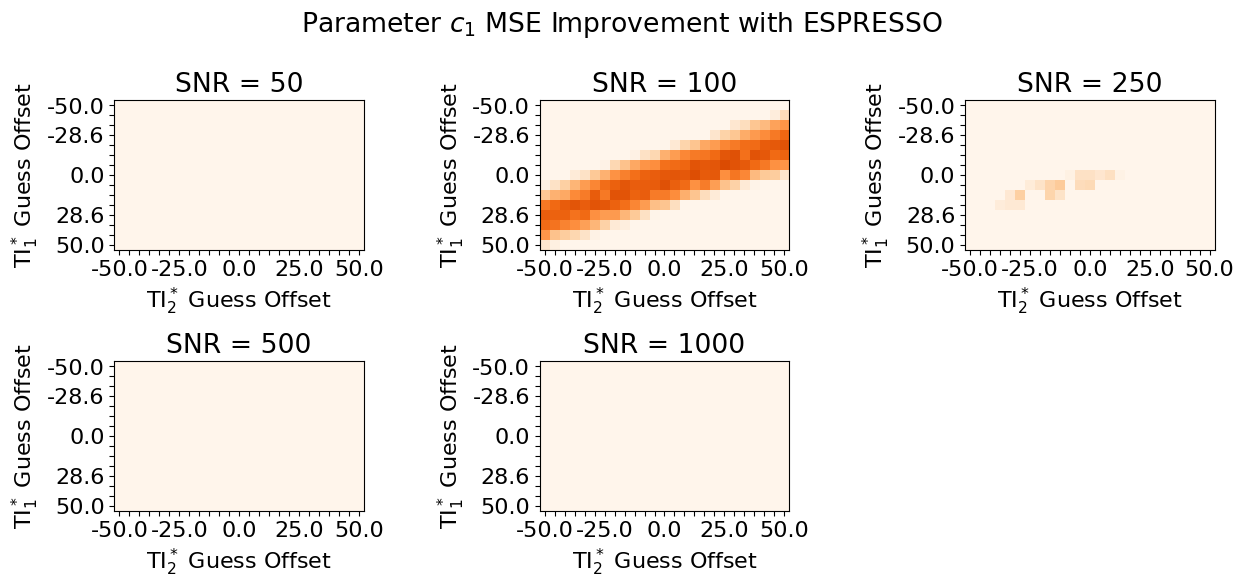

In [50]:
x_patches = [0,0,0,1,1]
y_patches = [0,1,2,0,1]

plt.rc('font', size = 16)
fig, ax_MSE = plt.subplots(2,3, figsize = (13, 6), tight_layout=True)
fig.suptitle(f"Parameter {ParamTitle_6p[param_oi]} MSE Improvement with ESPRESSO")

for ii in range(len(SNR_values)):
    temp_MSE_ESPRESSO = MSE[:,:,ii,0]

    SNR_index = np.where(SR_SNR==SNR_values[ii])[0][0]
    temp_SR_MSE = SR_MSE[SNR_index,2,param_oi]

    temp_MSE_imp = (temp_SR_MSE-temp_MSE_ESPRESSO)/temp_SR_MSE

    gen_patchwork_panel(ax_MSE, x_patches[ii], y_patches[ii], SNR_values[ii], temp_MSE_imp)

ax_MSE[1,2].remove()



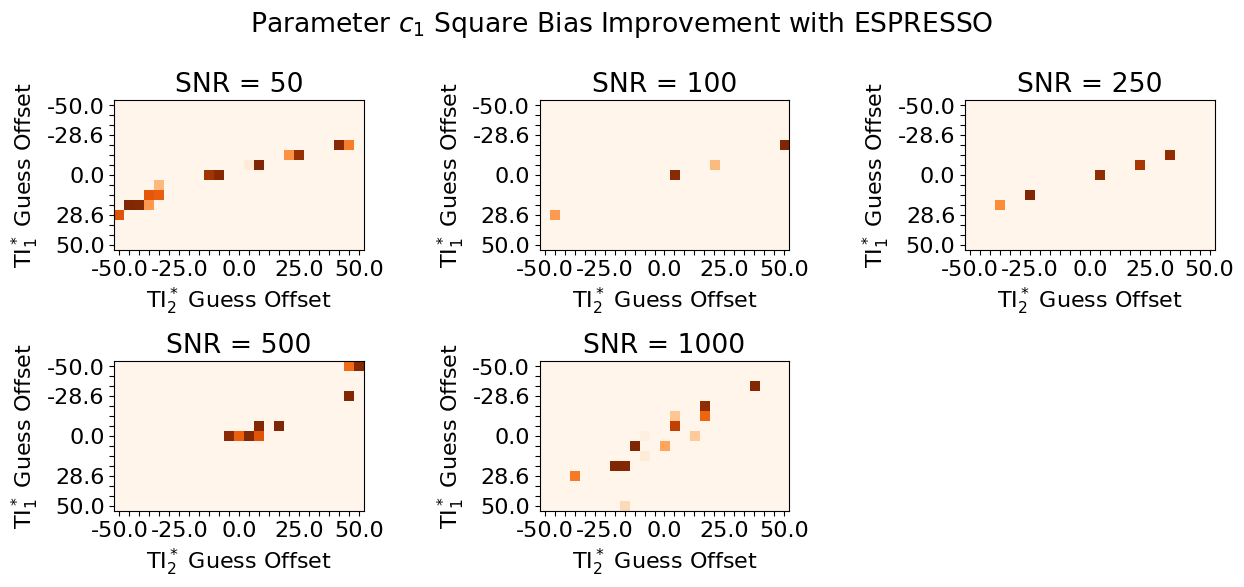

In [55]:
x_patches = [0,0,0,1,1]
y_patches = [0,1,2,0,1]


plt.rc('font', size = 16)
fig, ax_sqbias = plt.subplots(2,3, figsize = (13, 6), tight_layout=True)
fig.suptitle(f"Parameter {ParamTitle_6p[param_oi]} Square Bias Improvement with ESPRESSO")


for ii in range(len(SNR_values)):

    temp_bias_ESPRESSO = bias[:,:,ii,0]

    SNR_index = np.where(SR_SNR==SNR_values[ii])[0][0]
    temp_SR_bias = SR_BIAS[SNR_index,2,param_oi]
    temp_sqbias_imp = (temp_SR_bias**2-temp_bias_ESPRESSO**2)/temp_SR_bias**2

    gen_patchwork_panel(ax_sqbias, x_patches[ii], y_patches[ii], SNR_values[ii], temp_sqbias_imp)

ax_sqbias[1,2].remove()


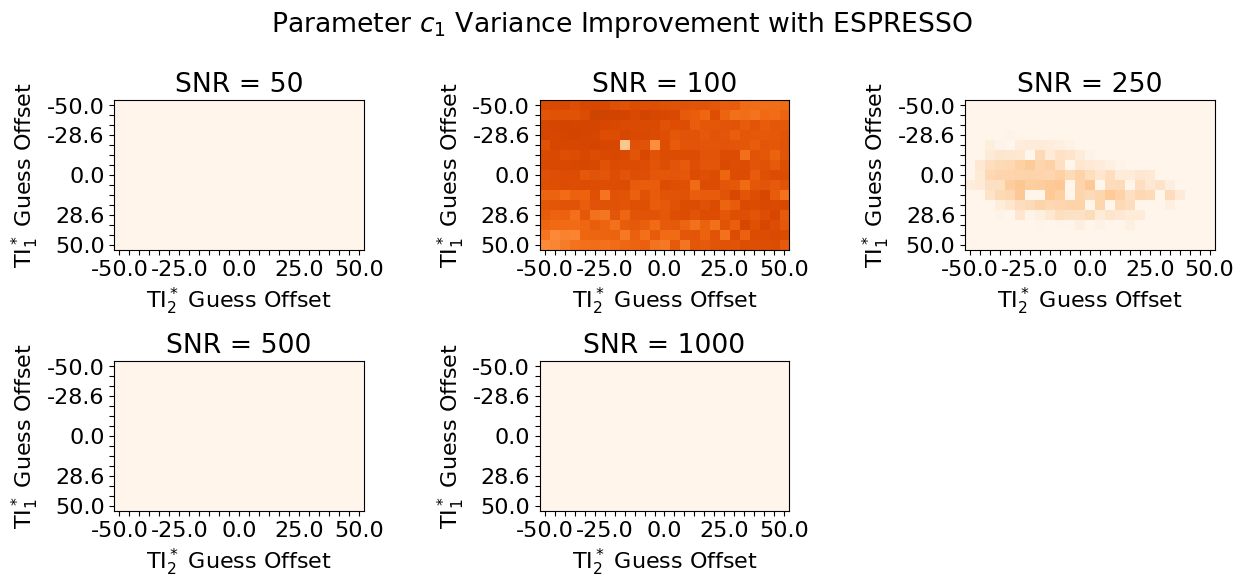

In [56]:
x_patches = [0,0,0,1,1]
y_patches = [0,1,2,0,1]


plt.rc('font', size = 16)
fig, ax_var = plt.subplots(2,3, figsize = (13, 6), tight_layout=True)
fig.suptitle(f"Parameter {ParamTitle_6p[param_oi]} Variance Improvement with ESPRESSO")

for ii in range(len(SNR_values)):
    temp_var_ESPRESSO = var[:,:,ii,0]

    SNR_index = np.where(SR_SNR==SNR_values[ii])[0][0]
    temp_SR_var = SR_VAR[SNR_index,2,param_oi]

    temp_var_imp = (temp_SR_var-temp_var_ESPRESSO)/temp_SR_var

    gen_patchwork_panel(ax_var, x_patches[ii], y_patches[ii], SNR_values[ii], temp_var_imp)

ax_var[1,2].remove()
